<a id = "table_of_contents"></a>
# Índice
[Objetivos del notebook](#objetivos)

[Importación de las principales librerías](#import_modules)

[Importación de los datos](#import_data)

[Exploratory Data Analysis (EDA)](#eda)

---> [EDA customers df](#df1)

---> [EDA orders df](#df2)

---> [EDA payments df](#df3)

[Creación de variables](#fe)

[Join final con clientes y variables finales](#join)

[Creación de nuestro Pipeline](#skpipeline)

[Elbow curve](#elbow_curve)

[Segmentación de los clientes con la "k adecuada"](#segmentacion)

[Ficha de clientes](#ficha)

[Conclusión](#conclusión)

<a id = "objetivos"></a>
# Objetivos del notebook
[Volver al índice](#toc)

En este notebook vamos a trabajar con el dataset de la **compañia brasileña de E-Commerce llamada Olist.**

La compañia opera con una filosofía de ***SaaS (Software as a Service)***. Su producto básico es un marketplace donde tiendas **con o sin presencia online pueden vender sus productos a los clientes que visitan su web.**

![Data Model](https://i.imgur.com/HRhd2Y0.png)

Utilizando el dataset de Olist (alrededor de 100 mil registros) vamos a construir una segmentacion basada en el algoritmo KMeans. El enfoque a la hora de construir variables será basado en el modelo de ***RFM (recency - frequency - monetary value).*** Esta es una forma de trabajar muy común en startups y tiendas online donde se dispone de poca información de los clientes y la retención/canje de los clicks es fundamental.

Nuestros principales objetivos serán:
1. **Construir variables de negocio (pensadas para nuestra segmentación)** a partir de 3 datasets diferentes y juntarlos de forma correcta para no generar duplicidades de registros.



2. **Aprender a utilizar el Pipeline de sklearn** para agilizar mucho la transformación del dataset y la creación de variables.



3. **Aprender a implementar nuestros propios Transformers** que se puedan usar dentro de los Pipelines (por ejemplo para eliminar los outliers).



4. Usar el diagrama del codo para determinar la cantidad **"óptima"** de centroides para el modelo de KMeans.



5. **Resumir la información de nuestros clústers en un formato más amigable** usando Pandas (fichas de clientes).

<a id = "import_modules"></a>
# Importación de las principales librerías
[Volver al índice](#table_of_contents)

En esta sección del kernel vamos a cargar las principales librerías que vamos a usar en nuestro notebook durante la implementación del algoritmo **KMeans.**

In [ ]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# python core library for machine learning and data science
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

RANDOM_STATE = 175
PATH_FOLDER = os.path.join(os.getcwd(), "olist_datasets")

In [ ]:
import sklearn
print(sklearn.__version__)

0.23.1


In [ ]:
PATH_FOLDER

'/Users/python10pm/Desktop/code/nuclio_new/03_KMeans/olist_datasets'

<a id = "import_data"></a>
# Importación de los datos
[Volver al índice](#table_of_contents)

En la presente sección del kernel vamos a cargar los principales datasets que vamos a usar para nuestra segmentación.

El alumno puede **añadir otros datasets o datos externos** para profundizar o experimentar con el algoritmo KMeans.

In [ ]:
PATH_CUSTOMERS = os.path.join(PATH_FOLDER, 'olist_customers_dataset.csv')

customer_df = pd.read_csv(PATH_CUSTOMERS)

In [ ]:
PATH_ORDERS = os.path.join(PATH_FOLDER, 'olist_orders_dataset.csv')

orders_df = pd.read_csv(PATH_ORDERS)

In [ ]:
PATH_PAYMENTS = os.path.join(PATH_FOLDER, 'olist_order_payments_dataset.csv')

payments_df = pd.read_csv(PATH_PAYMENTS)

<a id = "eda"></a>
# Exploratory Data Analysis (EDA)
[Volver al índice](#table_of_contents)

En la sección del EDA haremos **una primera aproximación a nuestros datos** para ver su composición y que variables tenemos a nuestra disposición.

<a id = "df1"></a>
# EDA customers df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de clientes.**

In [ ]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")

In [ ]:
report_df(customer_df)

customer_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None

Tenemos un total de 0 nulos


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
customer_id = customer_df["customer_id"].nunique()
customer_unique_id = customer_df["customer_unique_id"].nunique()

print(f'''Tenemos un total de {customer_unique_id} clientes únicos,\n
para un total de {customer_id} pedidos (en el esquema de Olist, especifican que el id único es customer_unique_id\n
y que customer_id es un id que se genera en cada compra y por tanto a la práctica viene a ser lo mismo que un pedido).
Esto implica un ratio de {round(customer_id/customer_unique_id, 2)} pedidos por cliente.
''')

Tenemos un total de 96096 clientes únicos,

para un total de 99441 pedidos (en el esquema de Olist, especifican que el id único es customer_unique_id

y que customer_id es un id que se genera en cada compra y por tanto a la práctica viene a ser lo mismo que un pedido).
Esto implica un ratio de 1.03 pedidos por cliente.



In [ ]:
# create a groupby DataFrame by customer city
city_pivot_ = customer_df.groupby(["customer_state", "customer_city"]).size()\
.sort_values(ascending = False).to_frame().reset_index().rename(columns = {0: "clients_per_city"})

city_pivot_["cumsum_by_city"] = (city_pivot_["clients_per_city"]/city_pivot_["clients_per_city"].sum()).cumsum()

city_pivot_["pct_cities"] = (1/city_pivot_.shape[0])
city_pivot_["pct_cities"] = city_pivot_["pct_cities"].cumsum()

In [ ]:
# create a groupby DataFrame by customer state
state_pivot_ = customer_df.groupby("customer_state").size()\
.sort_values(ascending = False).to_frame().reset_index().rename(columns = {0: "clients_per_state"})

state_pivot_["cumsum_by_state"] = (state_pivot_["clients_per_state"]/state_pivot_["clients_per_state"].sum()).cumsum()

state_pivot_["pct_state"] = (1/state_pivot_.shape[0])
state_pivot_["pct_state"] = state_pivot_["pct_state"].cumsum()

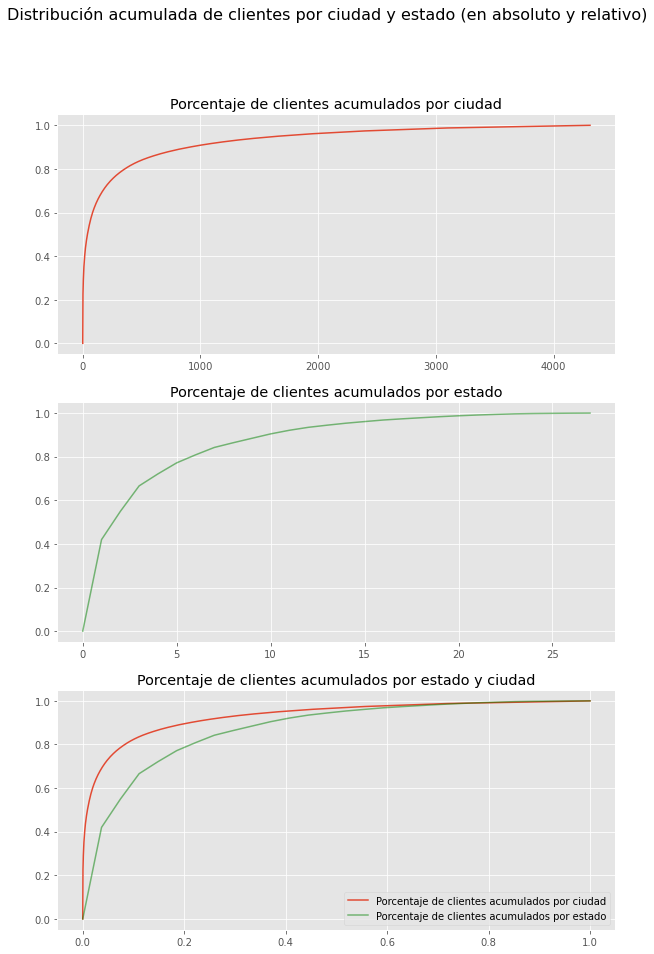

In [ ]:
#----------------------
# Plotting part

# instanciate the figure
fig = plt.figure(figsize = (10, 15))
ax1, ax2, ax3 = fig.subplots(nrows = 3, ncols = 1)

# get the data
# concate a zero before the list, so that all curves start at origin
x1_values = [0] + list(city_pivot_.index)
y1_values = [0] + list(city_pivot_["cumsum_by_city"])

x2_values = [0] + list(state_pivot_["cumsum_by_state"])
y2_values = [0] + list(state_pivot_["cumsum_by_state"])

x3_values_city = [0] + list(city_pivot_["pct_cities"])
y3_values_city = [0] + list(city_pivot_["cumsum_by_city"])

x3_values_state = [0] + list(state_pivot_["pct_state"])
y3_values_state = [0] + list(state_pivot_["cumsum_by_state"])

# plot the values and set for every subplot a title
ax1.plot(y1_values)
ax1.title.set_text("Porcentaje de clientes acumulados por ciudad")

ax2.plot(y2_values, color = "green", alpha = 0.5)
ax2.title.set_text("Porcentaje de clientes acumulados por estado")

ax3.plot(x3_values_city, y3_values_city, label = "Porcentaje de clientes acumulados por ciudad")
ax3.plot(x3_values_state, y3_values_state, label = "Porcentaje de clientes acumulados por estado", 
         color = "green", alpha = 0.5)
ax3.title.set_text("Porcentaje de clientes acumulados por estado y ciudad")

ax3.legend()

# create a title for the figure
fig.suptitle('Distribución acumulada de clientes por ciudad y estado (en absoluto y relativo)', fontsize = 16);

<a id = "df2"></a>
# EDA orders df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de pedidos.**

In [ ]:
report_df(orders_df)

orders_df.head(3).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None

Tenemos un total de 4908 nulos


,0,1,2
order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089
order_status,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49
order_approved_at,2017-10-02 11:07:15,2018-07-26 03:24:27,2018-08-08 08:55:23
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00


In [ ]:
orders_df["order_status"].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [ ]:
# tenemos nulls en las fechas, habrá o bien eliminar estos nulos o imputarles una fecha.
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [ ]:
order_id = orders_df["order_id"].nunique()
customer_id_orders = orders_df["customer_id"].nunique()

# nos aseguramos que todos los orders tiene su correspondiente cliente en la tabla de customers
assert (set(orders_df["customer_id"]) ^ set(customer_df["customer_id"])) == set()
assert (set(customer_df["customer_id"]) ^ set(orders_df["customer_id"])) == set()

print(f"Tenemos un total de {order_id} pedidos")
print(f"Tenemos un total de {customer_unique_id} customer únicos (de la tabla de customers)")
print(f"La relación de pedidos por clientes es de {round(order_id/customer_unique_id, 2)}")

Tenemos un total de 99441 pedidos
Tenemos un total de 96096 customer únicos (de la tabla de customers)
La relación de pedidos por clientes es de 1.03


<a id = "df3"></a>
# EDA payments df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de pagos.**

In [ ]:
report_df(payments_df)

payments_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
None

Tenemos un total de 0 nulos


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
payments_df['payment_sequential'].value_counts()

1     99360
2      3039
3       581
4       278
5       170
6       118
7        82
8        54
9        43
10       34
11       29
12       21
13       13
14       10
15        8
16        6
17        6
18        6
19        6
20        4
21        4
22        3
23        2
24        2
25        2
26        2
28        1
27        1
29        1
Name: payment_sequential, dtype: int64

In [ ]:
order_id_pay = payments_df["order_id"].nunique()
print(f"Tenemos un total de {order_id_pay} pedidos únicos en la tabla de payments")

Tenemos un total de 99440 pedidos únicos en la tabla de payments


In [ ]:
# nos aseguramos que todos los orders tiene su correspondiente cliente en la tabla de customers
len(set(orders_df["order_id"]))

99441

In [ ]:
orders_df["order_id"].shape

(99441,)

In [ ]:
orders_df["order_id"].nunique()

99441

In [ ]:
payments_df["order_id"].shape

(103886,)

In [ ]:
set(orders_df["order_id"]) ^ set(payments_df["order_id"])

{'bfbd0f9bdef84302105ad712db648a6c'}

In [ ]:
set(orders_df["order_id"])-set(payments_df["order_id"])

{'bfbd0f9bdef84302105ad712db648a6c'}

In [ ]:
set(payments_df["order_id"])-set(orders_df["order_id"])

set()

In [ ]:
orders_df[orders_df["order_id"] == "bfbd0f9bdef84302105ad712db648a6c"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00


<a id = "fe"></a>
# Creación de variables
[Volver al índice](#table_of_contents)

Hemos analizado los 3 datasets claves con los que vamos a trabajar.

En esta sección del notebook, **iremos agregando el dataset y vamos a generar nuevas variables** para que después en la siguiente sección lo juntamos en uno y hacemos la segmentación.

In [ ]:
payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
payments_df.shape

(103886, 5)

In [ ]:
def my_custom_agg(series):
    return np.sum(series * 2)

In [ ]:
def my_custom_discount(df, discount = 0.8):
    
    installments = df["payment_installments"]
    payment_value = df["payment_value"]
    
    max_installments = np.max(installments)
    
    if max_installments >= 3:
        return np.sum(payment_value) * discount

In [ ]:
payments_df.groupby("order_id").apply(my_custom_discount)

order_id
00010242fe8c5a6d1ba2dd792cb16214        NaN
00018f77f2f0320c557190d7a144bdd3    207.864
000229ec398224ef6ca0657da4fc703e    173.496
00024acbcdf0a6daa1e931b038114c75        NaN
00042b26cf59d7ce69dfabb4e55b4fd9    174.432
                                     ...   
fffc94f6ce00a00581880bf54a75a037        NaN
fffcd46ef2263f404302a634eb57f7eb        NaN
fffce4705a9662cd70adb13d4a31832d     93.480
fffe18544ffabc95dfada21779c9644f     51.768
fffe41c64501cc87c801fd61db3f6244        NaN
Length: 99440, dtype: float64

In [ ]:
payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
payments_df.groupby("order_id").agg(
    payment_value_mean = ("payment_value", np.mean),
    payment_value_sum = ("payment_value", np.sum)
    # payment_value_custom_sum = ("payment_value", my_custom_agg)
).head(3)

,payment_value_mean,payment_value_sum
order_id,,
00010242fe8c5a6d1ba2dd792cb16214,72.19,72.19
00018f77f2f0320c557190d7a144bdd3,259.83,259.83
000229ec398224ef6ca0657da4fc703e,216.87,216.87


In [ ]:
payments_df.pivot_table(
    index = "order_id",
    values = ["payment_value", "payment_sequential"],
    aggfunc = np.sum
)

,payment_sequential,payment_value
order_id,,
00010242fe8c5a6d1ba2dd792cb16214,1,72.19
00018f77f2f0320c557190d7a144bdd3,1,259.83
000229ec398224ef6ca0657da4fc703e,1,216.87
00024acbcdf0a6daa1e931b038114c75,1,25.78
00042b26cf59d7ce69dfabb4e55b4fd9,1,218.04
...,...,...
fffc94f6ce00a00581880bf54a75a037,1,343.40
fffcd46ef2263f404302a634eb57f7eb,1,386.53
fffce4705a9662cd70adb13d4a31832d,1,116.85


In [ ]:
# hacemos un groupby por order y calculamos algunas métricas básicas como max, min, media y similares.
# Hemos visto que gran parte de los pagos son únicos, por tanto coincidirán en la mayoría, pero en los demás casos
# nos van a aportar información útil sobre el cliente.

aggregated_payments = payments_df.groupby('order_id').agg(
    max_pay = ('payment_value', 'max'), 
    min_pay = ('payment_value', 'min'),
    mean_pay = ('payment_value', 'mean'),
    total_pay = ('payment_value', 'sum'),
    max_seq = ('payment_sequential', 'max')
)

In [ ]:
aggregated_payments[aggregated_payments["max_seq"] == 3]

In [ ]:
payments_df.shape

In [ ]:
aggregated_payments.shape

In [ ]:
orders_df.shape

In [ ]:
orders_with_payments = pd.merge(orders_df, aggregated_payments, on = 'order_id')

In [ ]:
orders_with_payments.shape

In [ ]:
report_df(orders_with_payments)

In [ ]:
orders_with_payments.head()

In [ ]:
#orders_with_payments["order_id_back"] = orders_with_payments["order_id"]
orders_with_payments.set_index('order_id', inplace = True)

In [ ]:
# convertimos las fechas al formato fechas dado que hasta ahora eran object y no nos permitían hacer
# casi ninguna transformación

orders_with_payments['order_purchase_timestamp'] =\
pd.to_datetime(orders_with_payments['order_purchase_timestamp'], format = '%Y-%m-%d')

orders_with_payments['order_delivered_customer_date'] =\
pd.to_datetime(orders_with_payments['order_delivered_customer_date'], format = '%Y-%m-%d')

In [ ]:
report_df(orders_with_payments)

In [ ]:
orders_with_payments['order_estimated_delivery_date'] =\
pd.to_datetime(orders_with_payments['order_estimated_delivery_date'], format = '%Y-%m-%d')

In [ ]:
report_df(orders_with_payments)

In [ ]:
# creamos variables útiles extrayendo la información de los pedidos.
# Por ejemplo: tiempo desde la última compra puede ser muy útil para que nuestro modelo detecte clientes
# recientes y combinando con la variable de pedidos totales podrá ser muy valiosas para segmentar a los clientes
# muy fidelizados.

orders_with_payments['last_purchase'] = orders_with_payments['order_purchase_timestamp'].max()

orders_with_payments['time_since_last_purchase'] =\
orders_with_payments['last_purchase'] - orders_with_payments['order_purchase_timestamp']

orders_with_payments['delivery_time'] =\
orders_with_payments['order_delivered_customer_date'] - orders_with_payments['order_purchase_timestamp']

orders_with_payments['delay'] =\
orders_with_payments['order_delivered_customer_date'] - orders_with_payments['order_estimated_delivery_date']

In [ ]:
orders_with_payments.head().T

<a id = "join"></a>
# Join final con clientes y variables finales
[Volver al índice](#table_of_contents)

In [ ]:
df_final = pd.merge(customer_df, orders_with_payments, on = "customer_id")

In [ ]:
df_final.set_index("customer_unique_id", inplace = True)

lc = [
    'max_pay',
    'min_pay',
    'mean_pay',
    'total_pay',
    'max_seq',
    'time_since_last_purchase',
    'delivery_time',
    'delay'
]

df_final = df_final[lc]

# extraemos los días de la variable timedelta que teníamos calculada previamente.
df_final["time_since_last_purchase"] = df_final["time_since_last_purchase"].dt.days
df_final["delivery_time"] = df_final["delivery_time"].dt.days
df_final["delay"] = df_final["delay"].dt.days

In [ ]:
df_final.head().T

In [ ]:
report_df(df_final)

df_final.sample(3).T

In [ ]:
# tenemos valores nulos y habrá que imputarlas de forma correcta en nuestro pipeline.
df_final.isnull().sum()

<a id = "skpipeline"></a>
# Creación de nuestro Pipeline
[Volver al índice](#table_of_contents)

Llegamos a este punto tenemos que hacer las últimas transformaciones de nuestro dataframe así como crear las últimas variables para nuestra segmentación.

Una forma de hacerlo es utilizar el pipeline de sklearn para automatizar todos estos pasos. Para ello tendremos que implementar nuestros propios ***"Transformers."***

Un ***Transformer*** en sklearn no es más una clase que tiene implementado el método **fit, transform  y fit_transform** (que puede realizar cualquier transformación sobre el dataset que le pasas).

No obstante, en la práctica sólo vamos a implementar un método, el **transform**, porque el **fit** (cuando heredamos de ***TransformerMixin***) sólo tiene que devolver el ***self*** y el **fit_transform** se va a crear sólo.

Heredamos también del ***BaseEstimator*** para tener acceso al método de ***get_params() y set_params()*** aunque en la práctica no lo vamos a usar.

In [ ]:
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    '''
    Clase que transforma un array en un DataFrame.
    Necesita como parámetros el nombre de las columnas y el índice.
    '''
    
    def __init__(self, columns, index = None):
        self.columns = columns
        self.index = index
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        if self.index != None:
            df = pd.DataFrame(X, columns = self.columns, index = self.index)
            
        else:
            df = pd.DataFrame(X, columns = self.columns)
            
        return df

In [ ]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    '''
    Clase que realiza unas transformaciones en el Pipeline.
    El dataset que le pasas debe ser un DataFrame válido.
    '''
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        aggregated_df = X.groupby(X.index).agg(
            n_orders = ('total_pay', 'count'),
            amount = ('total_pay', 'sum'),
            avg_ticket = ('total_pay', 'mean'),
            
            last_purchase = ('time_since_last_purchase', 'min'),
            first_purchase = ('time_since_last_purchase', 'max'),
            
            mean_delivery_time = ('delivery_time', 'mean'),
            max_delivery_time = ('delivery_time', 'max'),
            
            mean_delay = ('delay', 'mean'),
            max_delay = ('delay', 'max')
        )
        
        return aggregated_df

Los ***outliers*** pueden distorsionar mucho nuestro KMeans, pudiendo llegar a crear grupos de 1 sólo cliente.

Para que esto no ocurra, tenemos que eliminar cualquier posible ***outlier.*** y luego estandarizar o normalizar nuestros datos.

A continuación vamos a implementar nuestro propio ***OutlierFilter***

In [ ]:
class OutlierFilter(BaseEstimator, TransformerMixin):
    '''
    Clase que filtra los outliers utilizando np.quantile()
    Los cuantiles a filtrar así como las columnas a filtrar son los parámetros de la clase.
    '''
    
    def __init__(self, q, col_to_filter):
        self.q = q
        self.col_to_filter = col_to_filter
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        '''
        El método considera outlier a aquel cliente que es outlier en todas las columnas que le pasas.
        Es decir: si tiene que filtrar importe y número de pedidos, sólo va a eliminar aquellos clientes
        que son outlier tanto en importe como número de pedidos. Si eres outlier en importe pero no en pedido
        no se te va a filtrar del dataset.
        '''
        
        # lista vacía
        criteria_list = []
        
        # agregamos a la lista los clientes que son outliers
        for col in self.col_to_filter:
            criteria = X[col] < np.quantile(X[col], q = self.q)
            criteria_list.append(criteria)
            
        # si hay más de 1 columna
        if len(self.col_to_filter) > 1:
            
            # creamos el criterio global: es decir outlier en todas las columnas
            global_criteria = criteria_list[0]
            
            for criteria in criteria_list[1:]:
                global_criteria = global_criteria & criteria
                
        else:
            global_criteria = criteria_list[0]
            
        # filtramos nuestra dataframe
        X = X[global_criteria]
        
        # guardamos el índice como parámetro de la clase porque en caso contrario lo perderíamos.
        self.index = X.index
        
        return X

In [ ]:
df_back = df_final.copy(deep = True)

In [ ]:
df_final.shape

In [ ]:
# df_final = df_back.sample(15000)
df_final = df_back.copy(deep = True)
columns = list(df_final.columns)
index = list(df_final.index)

Llegamos a este punto tenemos todo listo para construir nuestro pipeline.

Los pasos que va a realizar son:

1. Usar el ***KNNImputer***, que se basa en la misma noción de **métricas de distancia** para imputar los valores nulos en función de los cliente más similares.

2. Dado que en el primer paso, nos devuelve un array, usamos nuestro propio ***Transformer*** para convertir a DataFrame.

3. Creamos variables a nivel de cliente. **POR TANTO VAMOS NUESTRO DATAFRAME DE SALIDA SERÁ MÁS PEQUEÑO.**

4. Filtramos los outliers con nuestro propio ***Transformer***. **POR TANTO VAMOS NUESTRO DATAFRAME DE SALIDA SERÁ MÁS PEQUEÑO.**

5. Estandarizamos los valores, usando ***StandardScaler***.

6. Hacemos un fit con KMeans para calcular la **inertia** de los grupos (la dispersión de los datos al centroide).

Técnica del ***Elbow Curve***: todo esto lo hacemos en una loop porque queremos ver cuando hay un cambio brusco en la inertia y por tanto, **aumentar más el número de centroides no nos sale a cuenta porque la ganacia marginal es muy pequeña.**

In [ ]:
CALCULATE_ELBOW = True

In [ ]:
# separamos el pipeline del a loop, para no tener que volver a hacer los primeros 5 pasos para cada k de la loop
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()),
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("FeatureGenerator", FeatureGenerator()),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["amount", "max_delay"])),
    ("StandardScaler", StandardScaler())
])

In [ ]:
df_scaled_transformed_no_outliers = pipe.fit_transform(df_final)

In [ ]:
if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 15):

        print(f"Fitting pipe with {k} clusters")

        clustering_model = KMeans(n_clusters = k)

        clustering_model.fit(df_scaled_transformed_no_outliers)

        sse[k] = clustering_model.inertia_

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st)/60), 2))

In [ ]:
sse

<a id = "elbow_curve"></a>
# Elbow curve
[Volver al índice](#table_of_contents)

En esta sección vamos a visualizar nuestro ***Elbow Curve*** y buscaremos el punto de inflexión que será nuestro número de centroides.

In [ ]:
# df_final = pd.read_csv
df_final.isnull().sum()

In [ ]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

<a id = "segmentacion"></a>
# Segmentación de los clientes con la "k adecuada"
[Volver al índice](#table_of_contents)

Ahora que hemos determinado el número de centroides correcto podemos fittear nuestro pipeline con la ***k adecuada.***

Dado que vamos a realizar nuestra segmentación con KMeans y vamos a suministrarle las variables de nuestro interés, a veces, a KMeans se le conoce como **segmentación no supervisada pero guiada***. Guiada porque de alguna manera el data scientist le dice (lo guía) a que discrimine usando unas variables y no otras.

In [ ]:
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()), 
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("FeatureGenerator", FeatureGenerator()),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["amount", "max_delay"])),
    ("StandardScaler", StandardScaler()),
    ("Clustering", KMeans(n_clusters = 5))
])

In [ ]:
df_final.shape

In [ ]:
pipe.fit(df_final)

Una parte muy interesante de los pipelines es que la podemos filtrar (igual que una lista de python) y usar sólo parte de los pasos que tenemos implementados. 

Esto viene muy útil porque en nuestro caso, cuando vamos a hacer el predict (asignar a cada cliente su centroide), queremos imputar los nulos, crear las variables necesarias y estandarizar (paso 1, 3 y 5 del pipe), pero **no filtrar los outliers** (todos los clientes tienen que tener un grupo). Si hacemos el predict con todo el pipeline, algunos clientes no se van a asignar a ningún grupo.

In [ ]:
# creamos un dataframe escalado con los pasos 1 - 3 y 5
X_processed = pipe[:3].transform(df_final)
X_scaled = pipe["StandardScaler"].transform(X_processed)

# perdemos clientes por el paso 3: clientes con más de 1 pedido o pago, se acaba agrupando en 1 único registro.
X_scaled.shape

In [ ]:
# hacemos el predict, en este caso tendremos para cada cliente su centroide/clúster.
labels = pipe["Clustering"].predict(X_scaled)

In [ ]:
pipe["Clustering"]

In [ ]:
# le asignamos al DataFrame procesado los centroides.
# SI LO HACEMOS AL ESCALADO LOS NÚMEROS PERDERAN SU SIGNIFICADO ESCALA Y SERÁN MÁS DÍFICILES DE INTERPRETAR.
X_processed["cluster"] = labels

In [ ]:
X_processed.shape

In [ ]:
# visualizamos nuestros grupos en base a las variables del modelo RFM, para ver que tal han quedado.
selected_columns = ['n_orders', 'amount', 'last_purchase']

sns.pairplot(X_processed, vars = selected_columns, hue = 'cluster');

<a id = "ficha"></a>
# Ficha de los clientes
[Volver al índice](#table_of_contents)

El último paso, usa vez que tenemos hecha nuestra segmentación completa es crear una ***ficha resumen*** de cada grupo con las principales variables de negocio o con aquellas que no se han utilizado en la segmentación para hacer un seguimiento periódico de los grupos o para enviar como documento al resto de los departamentos de la empresa.

In [ ]:
ficha_df = pd.DataFrame()
ficha_df

In [ ]:
for i, col in enumerate(["amount", "n_orders", "last_purchase", "mean_delay"]):
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

In [ ]:
resumen_data

In [ ]:
# generamos nuestro multiindex
out_index = [
    "Monetarios",
    "Fidelización",
    "Fidelización",
    "Logística"
]

inner_index = [
    "Importe",
    "Nr. de compras",
    "Última compra",
    "Retrasos"
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))
        
new_multi_index

In [ ]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [ ]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [ ]:
tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [ ]:
ficha_df = tamaño_clusters.append(ficha_df)

In [ ]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

<a id = "conclusión"></a>
# Conclusión
[Volver al índice](#table_of_contents)

Los algoritmos no supervisados son herramientas **muy potentes** que cualquier data scientist debe tener a mano. Saber el funcionamiento y hacer la correcta implementación de estos, puede permitir **extraer información muy valiosa y tomar mejores decisiones de negocio**. Hemos visto el algoritmo de KMenas que nos permiten crear **grupos homogéneos y accionables** de clientes y así mejorar los indicadores de la compañia.

Además de esto, hemos aprendido a utilizar los pipelines de sklearn para **automatizar al máximo el tratamiento de datos** así como implementar nuestros propios ***Transformers*** que puede ser utilizados dentro del pipeline.